In [3]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pandas as pd
import numpy as np
from collections import Counter
from plotnine import ggplot, aes, geom_bar, coord_flip, labs, theme_classic, scale_y_continuous, scale_color_discrete, guides, geom_col, scale_fill_manual 

/home/djl294/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


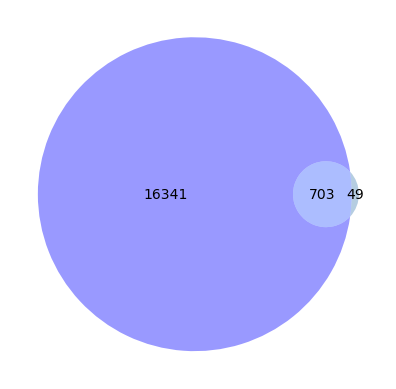

In [4]:
def read_identifiers(file):
    with open(file, 'r') as f:
        lis = []
        lines = f.readlines()
        for line in lines:
            identifier = line.strip()
            lis.append(identifier)
        return set(lis)
        


# Read identifiers from the two files
fs_identifiers = read_identifiers("FS_tacc.u") # Target accessions of foldseekk hits (after quality filtering)
hmmer_identifiers = read_identifiers("HMMER_tacc.u")# Target accessions of hmmer hits (after quality filtering)


# Create a Venn diagram
venn2([fs_identifiers, hmmer_identifiers], ('', ''), set_colors=("Blue", "steelblue"))


# Display the plot
plt.title("")
plt.savefig("Foldseek_HMMER_venn.svg")
plt.show()

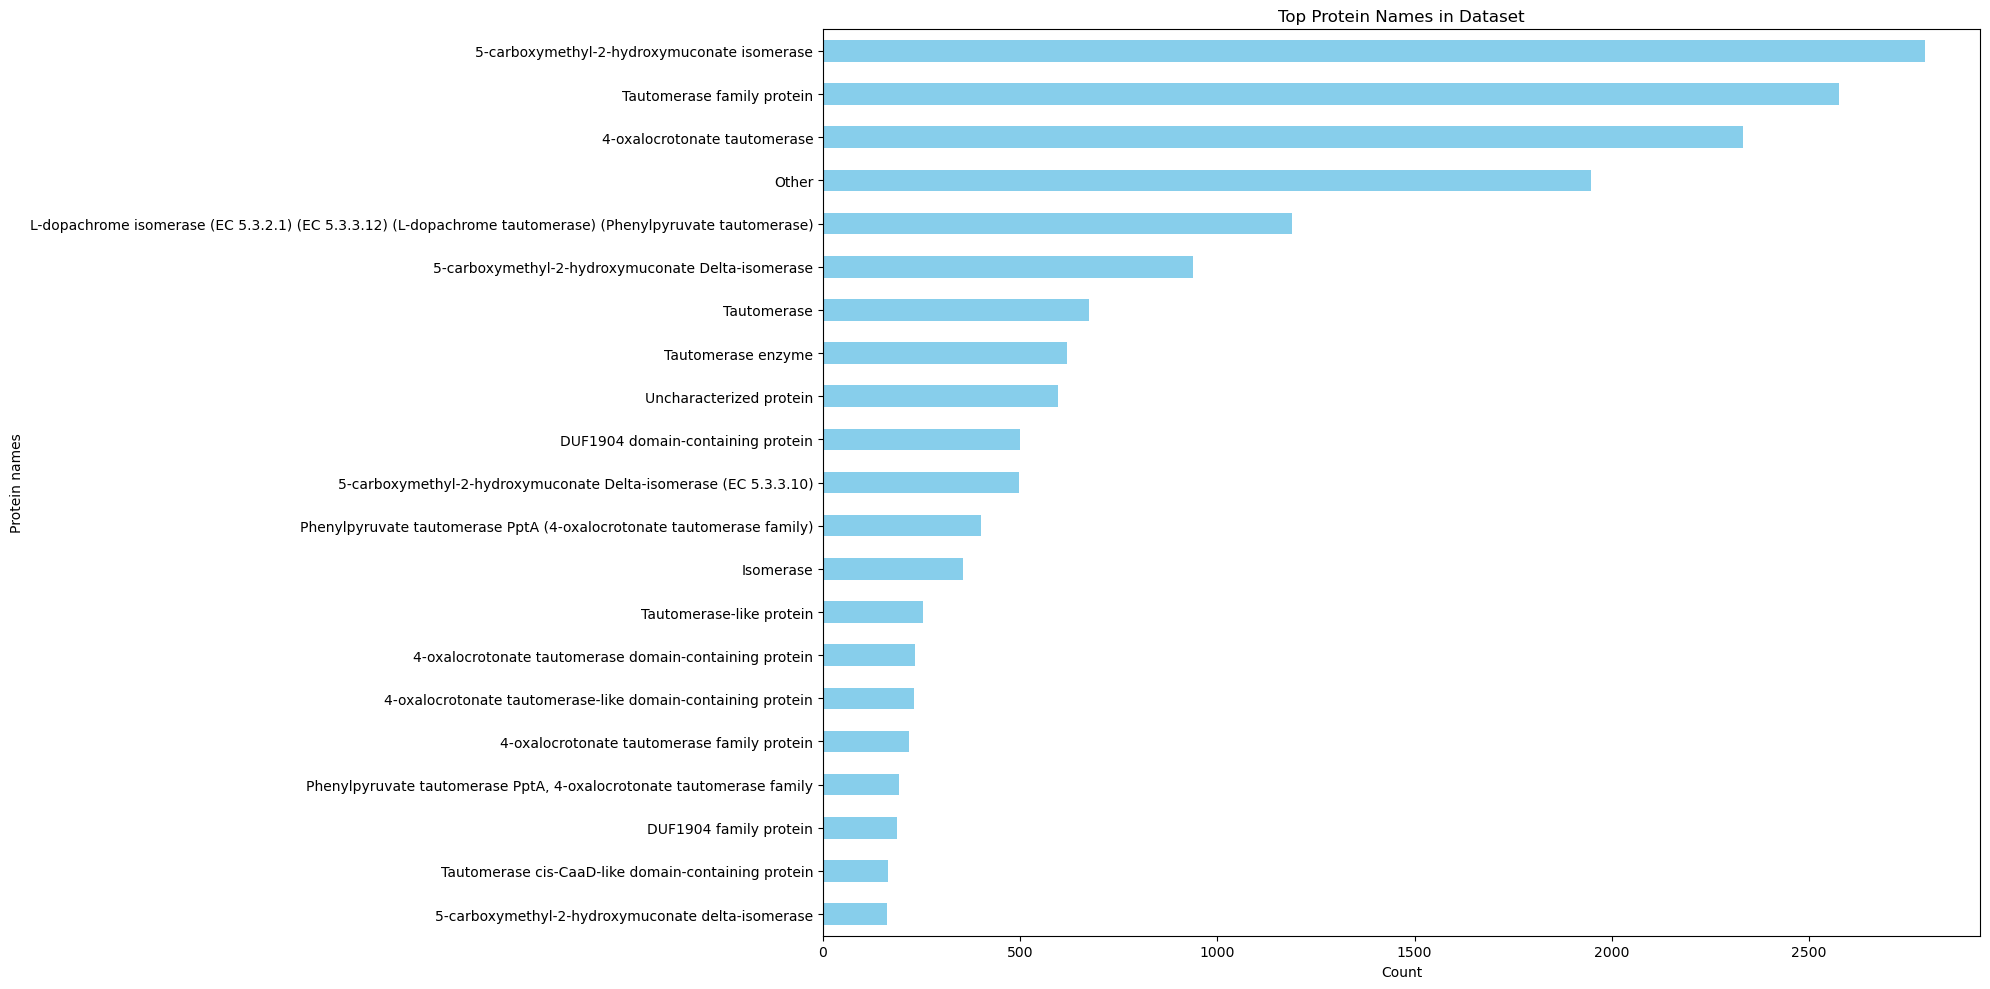

Protein names
5-carboxymethyl-2-hydroxymuconate isomerase                                                                  2794
Tautomerase family protein                                                                                   2577
4-oxalocrotonate tautomerase                                                                                 2332
L-dopachrome isomerase (EC 5.3.2.1) (EC 5.3.3.12) (L-dopachrome tautomerase) (Phenylpyruvate tautomerase)    1189
5-carboxymethyl-2-hydroxymuconate Delta-isomerase                                                             938
Tautomerase                                                                                                   675
Tautomerase enzyme                                                                                            618
Uncharacterized protein                                                                                       597
DUF1904 domain-containing protein                                         

In [5]:

# Load data
names = pd.read_csv("combined_uniprot_protnames", sep="\t")

# Count occurrences of each protein name
protein_counts = names['Protein names'].value_counts()

# Optional: Limit to top N to avoid clutter
top_n = 20
protein_counts_top = protein_counts.nlargest(top_n)
other_count = protein_counts.iloc[top_n:].sum()
protein_counts_top['Other'] = other_count

# Plot horizontal bar chart
plt.figure(figsize=(20, 10))
protein_counts_top.sort_values().plot.barh(color='skyblue')  # sort for visual clarity

plt.xlabel("Count")
plt.title("Top Protein Names in Dataset")
plt.tight_layout()
plt.show()

print(protein_counts_top)



In [7]:
## Get family, genus, species data for each accesion


acc2taxid = {}
df_taxa = pd.read_csv("tmp.tacc2txid.u", sep="\t") #target accession (Uniref90 Representative) to NCBI_identifier mapping, from UniProts Mapping Tool


#Turn UniProt Mapping to Python Dict
for index, row in df_taxa.iterrows():
    acc = row[0]
    tax_id = row[2]
    acc2taxid[acc] = tax_id
acc2taxid    

/tmp/ipykernel_1074402/203270583.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_1074402/203270583.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


{'A0A009H1Z0': 1310608,
 'A0A009HCT7': 1310608,
 'A0A009HRD8': 1310613,
 'A0A009I523': 1310613,
 'A0A009N468': 1310652,
 'A0A009N6V0': 1310652,
 'A0A009PD57': 1310607,
 'A0A009QCK8': 1310607,
 'A0A009R8H0': 1310637,
 'A0A009RT57': 1310637,
 'A0A009SI62': 1310630,
 'A0A009TGX8': 1310630,
 'A0A009YTH9': 1310601,
 'A0A009ZCB5': 1310601,
 'A0A010INF0': 1310681,
 'A0A010JMD3': 1310681,
 'A0A010RN88': 1042209,
 'A0A011MJ67': 85402,
 'A0A011UXL5': 1341156,
 'A0A011VUM0': 1341156,
 'A0A013T945': 1310791,
 'A0A013TCJ8': 1310791,
 'A0A013TSB9': 1310764,
 'A0A013UUB9': 1310764,
 'A0A014KZH8': 1158056,
 'A0A014L8W3': 1158056,
 'A0A014MBQ3': 69222,
 'A0A014ME04': 1158056,
 'A0A014MEZ2': 1158056,
 'A0A014Q9J3': 1457173,
 'A0A016XD06': 1458275,
 'A0A016XKK4': 1458275,
 'A0A017HPD5': 442562,
 'A0A017RWW7': 1403537,
 'A0A017T4D9': 1192034,
 'A0A021VSG6': 948458,
 'A0A021X158': 1410620,
 'A0A021X2N5': 1410620,
 'A0A022FWJ5': 574750,
 'A0A022G2K5': 574750,
 'A0A022GKV3': 574750,
 'A0A022J069': 1310723,
 

In [12]:

    
cols = [
    "Query",
    "Taxid",
    "Tax name",
    "Authority",
    "Rank",
    "Basionym",
    "Basionym authority",
    "Curator common name",
    "Has type material",
    "Group name",
    "Superkingdom name",
    "Superkingdom taxid",
    "Kingdom name",
    "Kingdom taxid",
    "Phylum name",
    "Phylum taxid",
    "Class name",
    "Class taxid",
    "Order name",
    "Order taxid",
    "Family name",
    "Family taxid",
    "Genus name",
    "Genus taxid",
    "Species name",
    "Species taxid",
    "Scientific name is formal"
]    
    
    
    
    

combined_taxa_df = pd.DataFrame(columns=cols)
#Use NCBI taxanomy summary files to get family, genus, species given a taxid
#def get_taxa(TaxID):

accs = []
exceptions = []
for key, value in acc2taxid.items():
    try:
        path = f'/workdir/djl294/NCBI_tax_MIF/{value}/ncbi_dataset/data/taxonomy_summary.tsv'
        summary_df = pd.read_csv(path, sep="\t")
        combined_taxa_df = pd.concat([combined_taxa_df, summary_df])
        accs.append(key)
        

        
    except Exception as e:
        print(f'{value} error: {e}')
        exceptions.append(value)

combined_taxa_df['ACC'] = accs
combined_taxa_df

50340 error: [Errno 2] No such file or directory: '/workdir/djl294/NCBI_tax_MIF/50340/ncbi_dataset/data/taxonomy_summary.tsv'
50340 error: [Errno 2] No such file or directory: '/workdir/djl294/NCBI_tax_MIF/50340/ncbi_dataset/data/taxonomy_summary.tsv'
50340 error: [Errno 2] No such file or directory: '/workdir/djl294/NCBI_tax_MIF/50340/ncbi_dataset/data/taxonomy_summary.tsv'
50340 error: [Errno 2] No such file or directory: '/workdir/djl294/NCBI_tax_MIF/50340/ncbi_dataset/data/taxonomy_summary.tsv'
50340 error: [Errno 2] No such file or directory: '/workdir/djl294/NCBI_tax_MIF/50340/ncbi_dataset/data/taxonomy_summary.tsv'
404407 error: [Errno 2] No such file or directory: '/workdir/djl294/NCBI_tax_MIF/404407/ncbi_dataset/data/taxonomy_summary.tsv'
68044 error: [Errno 2] No such file or directory: '/workdir/djl294/NCBI_tax_MIF/68044/ncbi_dataset/data/taxonomy_summary.tsv'
68044 error: [Errno 2] No such file or directory: '/workdir/djl294/NCBI_tax_MIF/68044/ncbi_dataset/data/taxonomy_sum

,Query,Taxid,Tax name,Authority,Rank,Basionym,Basionym authority,Curator common name,Has type material,Group name,...,Family name,Family taxid,Genus name,Genus taxid,Species name,Species taxid,Scientific name is formal,Domain/Realm name,Domain/Realm taxid,ACC
0,1310608,1310608,Acinetobacter sp. 1295259,NaN,SPECIES,NaN,NaN,NaN,no,g-proteobacteria,...,Moraxellaceae,468,Acinetobacter,469,Acinetobacter sp. 1295259,1310608,False,Bacteria,2.0,A0A009H1Z0
0,1310608,1310608,Acinetobacter sp. 1295259,NaN,SPECIES,NaN,NaN,NaN,no,g-proteobacteria,...,Moraxellaceae,468,Acinetobacter,469,Acinetobacter sp. 1295259,1310608,False,Bacteria,2.0,A0A009HCT7
0,1310613,1310613,Acinetobacter baumannii 1295743,NaN,STRAIN,NaN,NaN,NaN,no,g-proteobacteria,...,Moraxellaceae,468,Acinetobacter,469,Acinetobacter baumannii,470,False,Bacteria,2.0,A0A009HRD8
0,1310613,1310613,Acinetobacter baumannii 1295743,NaN,STRAIN,NaN,NaN,NaN,no,g-proteobacteria,...,Moraxellaceae,468,Acinetobacter,469,Acinetobacter baumannii,470,False,Bacteria,2.0,A0A009I523
0,1310652,1310652,Acinetobacter sp. 1475718,NaN,SPECIES,NaN,NaN,NaN,no,g-proteobacteria,...,Moraxellaceae,468,Acinetobacter,469,Acinetobacter sp. 1475718,1310652,False,Bacteria,2.0,A0A009N468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1299321,1299321,Mycobacteroides abscessus subsp. bolletii 1513,NaN,STRAIN,NaN,NaN,NaN,no,high G+C Gram-positive bacteria,...,Mycobacteriaceae,1762,Mycobacteroides,670516,Mycobacteroides abscessus,36809,False,Bacteria,2.0,X8DIB9
0,936563,936563,Fusobacterium sp. CM22,NaN,SPECIES,NaN,NaN,NaN,no,fusobacteria,...,Fusobacteriaceae,203492,Fusobacterium,848,Fusobacterium sp. CM22,936563,False,Bacteria,2.0,X8GZX3
0,1032505,1032505,Fusobacterium sp. OBRC1,NaN,SPECIES,NaN,NaN,NaN,no,fusobacteria,...,Fusobacteriaceae,203492,Fusobacterium,848,Fusobacterium sp. OBRC1,1032505,False,Bacteria,2.0,X8HN85
0,936561,936561,Fusobacterium sp. CM1,NaN,SPECIES,NaN,NaN,NaN,no,fusobacteria,...,Fusobacteriaceae,203492,Fusobacterium,848,Fusobacterium sp. CM1,936561,False,Bacteria,2.0,X8I072


In [16]:


def get_taxa_ratios(Target_Taxa):
    Target_Taxa_List = []
    level_index = combined_taxa_df.columns.get_loc(Target_Taxa)
    for i, row in combined_taxa_df.iterrows():
        tax_name = row[level_index]
        Target_Taxa_List.append(tax_name)
            
    counts = Counter(Target_Taxa_List)
    total_counts = sum(list(counts.values()))
    total_counts
    
    
    percent_dict = {}
    for key, value in counts.items():
        percent = value/total_counts * 100
        percent_dict[key] = percent
        
    n = len(percent_dict.keys())
    Levels = [Target_Taxa] * n
    sub_df = pd.DataFrame({
        "Level": Levels,
        "Label": percent_dict.keys(),
        "Perc": percent_dict.values()
    })
    
    return sub_df
    


phylum_plot_df = get_taxa_ratios("Phylum name")
  
print(phylum_plot_df)
    
    
    
family_plot_df = get_taxa_ratios("Family name")
  
print(family_plot_df)
    
genus_plot_df = get_taxa_ratios("Genus name")
  
print(genus_plot_df)

species_plot_df = get_taxa_ratios("Species name")
  
print(species_plot_df)

/tmp/ipykernel_1074402/3529146481.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


          Level                              Label       Perc
0   Phylum name                     Pseudomonadota  61.927062
1   Phylum name                          Bacillota  10.419716
2   Phylum name                     Actinomycetota  16.876427
3   Phylum name                        Myxococcota   0.433179
4   Phylum name                       Bacteroidota   2.710297
..          ...                                ...        ...
62  Phylum name                      Calditrichota   0.017561
63  Phylum name                     Fibrobacterota   0.017561
64  Phylum name                    Fidelibacterota   0.005854
65  Phylum name  Candidatus Handelsmaniibacteriota   0.005854
66  Phylum name        Candidatus Rifleibacteriota   0.005854

[67 rows x 3 columns]


/tmp/ipykernel_1074402/3529146481.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


           Level                       Label      Perc
0    Family name               Moraxellaceae  3.032254
1    Family name            Pseudomonadaceae  6.532810
2    Family name             Pasteurellaceae  0.614646
3    Family name            Oscillospiraceae  0.556108
4    Family name           Streptomycetaceae  5.953287
..           ...                         ...       ...
408  Family name          Geitlerinemataceae  0.005854
409  Family name               Xenococcaceae  0.005854
410  Family name  Candidatus Korobacteraceae  0.005854
411  Family name          Symbiobacteriaceae  0.005854
412  Family name             Microthrixaceae  0.005854

[413 rows x 3 columns]


/tmp/ipykernel_1074402/3529146481.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


           Level                     Label      Perc
0     Genus name             Acinetobacter  2.546391
1     Genus name               Pseudomonas  6.281098
2     Genus name                Mannheimia  0.046830
3     Genus name              Ruminococcus  0.228297
4     Genus name              Streptomyces  5.590353
...          ...                       ...       ...
1407  Genus name  Candidatus Competibacter  0.011708
1408  Genus name          Commensalibacter  0.005854
1409  Genus name           Intrasporangium  0.005854
1410  Genus name               Imhoffiella  0.005854
1411  Genus name         Agrilactobacillus  0.005854

[1412 rows x 3 columns]


/tmp/ipykernel_1074402/3529146481.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


             Level                             Label      Perc
0     Species name         Acinetobacter sp. 1295259  0.011708
1     Species name           Acinetobacter baumannii  0.286835
2     Species name         Acinetobacter sp. 1475718  0.011708
3     Species name          Acinetobacter sp. 809848  0.011708
4     Species name          Acinetobacter sp. 479375  0.011708
...            ...                               ...       ...
8041  Species name           Marinomonas ushuaiensis  0.011708
8042  Species name            Fusobacterium sp. CM22  0.005854
8043  Species name           Fusobacterium sp. OBRC1  0.005854
8044  Species name             Fusobacterium sp. CM1  0.005854
8045  Species name  Brachybacterium phenoliresistens  0.005854

[8046 rows x 3 columns]


In [41]:
def plot_taxa_distribution(df, top_n=5, title_prefix=''):
 

    # Ensure 'Perc' is numeric
    df['Perc'] = pd.to_numeric(df['Perc'], errors='coerce')

    # Drop rows where 'Perc' is missing
    df = df.dropna(subset=['Perc'])

    # Separate rows with valid labels and those with NaN labels
    valid_df = df.dropna(subset=['Label'])
    nan_label_perc = df[df['Label'].isna()]['Perc'].sum()

    # Sort valid rows by percentage
    df_sorted = valid_df.sort_values('Perc', ascending=False).reset_index(drop=True)

    # Keep top N and group rest + NaNs as "Other"
    top_df = df_sorted.iloc[:top_n].copy()
    other_perc = df_sorted.iloc[top_n:]['Perc'].sum() + nan_label_perc

    if other_perc > 0:
        # Build 'Other' row with same columns as top_df
        other_row = pd.DataFrame([{
            'Level': top_df['Level'].iloc[0] if 'Level' in top_df.columns else '',
            'Label': 'Other',
            'Perc': other_perc
        }])
        top_df = pd.concat([top_df, other_row], ignore_index=True)

    # Plot Pie Chart
    plt.figure(figsize=(8, 6))
    plt.pie(top_df['Perc'], labels=top_df['Label'], autopct='%1.1f%%', startangle=140)
    plt.title(f'{title_prefix}Taxa Distribution (Pie Chart)')
    plt.tight_layout()
    plt.show()

    # Plot Horizontal Bar Chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_df['Label'], top_df['Perc'], color='skyblue')
    plt.xlabel('Percentage')
    plt.title(f'{title_prefix}Taxa Distribution (Bar Chart)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return top_df  # Optionally return for inspection or saving


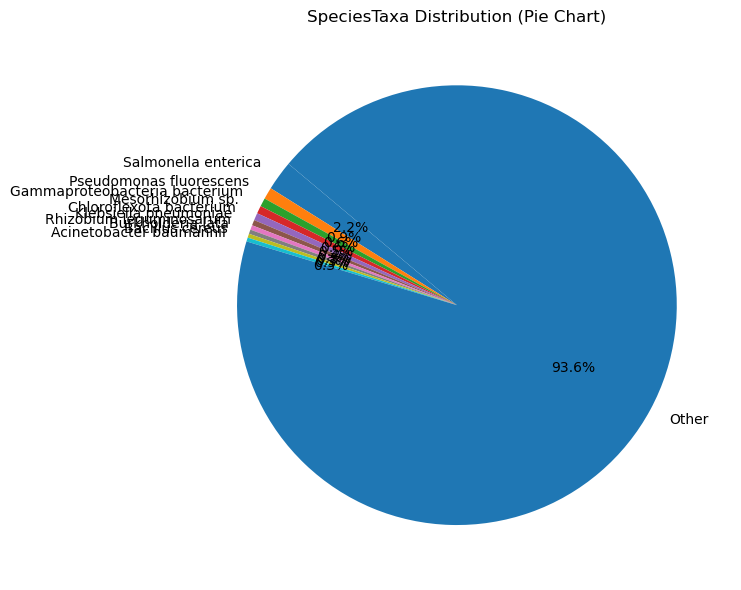

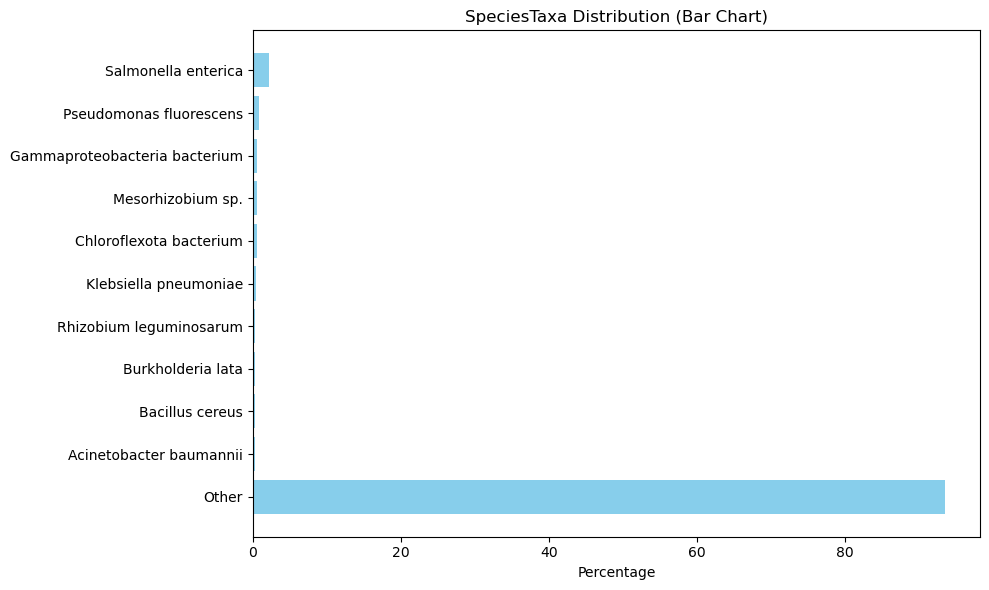

,Level,Label,Perc
0,Species name,Salmonella enterica,2.189311
1,Species name,Pseudomonas fluorescens,0.866358
2,Species name,Gammaproteobacteria bacterium,0.620500
3,Species name,Mesorhizobium sp.,0.573670
4,Species name,Chloroflexota bacterium,0.538547
5,Species name,Klebsiella pneumoniae,0.403910
6,Species name,Rhizobium leguminosarum,0.339519
7,Species name,Burkholderia lata,0.316104
8,Species name,Bacillus cereus,0.292689
9,Species name,Acinetobacter baumannii,0.286835


In [47]:
plot_taxa_distribution(species_plot_df, top_n=10, title_prefix='Species')

In [35]:
print(top_df.dtypes)

NameError: name 'top_df' is not defined